In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm 
import numpy as np
from PIL import Image
import os

dataset_dir = "./data/images"  

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  
])

def calculate_mean_std(dataset_dir):
    mean = np.zeros(3)
    std = np.zeros(3)
    n_images = 0

    for fname in os.listdir(dataset_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(dataset_dir, fname)
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image).numpy()
            mean += image_tensor.mean(axis=(1, 2))
            std += image_tensor.std(axis=(1, 2))
            n_images += 1

    mean /= n_images
    std /= n_images
    return mean, std

mean, std = calculate_mean_std(dataset_dir)
print(f"Mean: {mean}, Std: {std}")


In [5]:

class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=1)
        )
        
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # Pixel değerleri [0, 1] aralığında olacak
        )
        
    def forward(self, x):
        return self.decoder(x)

class VQVAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=64, num_embeddings=512):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, latent_dim)
        self.decoder = Decoder(latent_dim, in_channels)
        self.codebook = nn.Embedding(num_embeddings, latent_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
    
    def forward(self, x):
        z_e = self.encoder(x) 
        z_e_flattened = z_e.view(z_e.size(0), -1, z_e.size(1))
        
        distances = torch.cdist(z_e_flattened, self.codebook.weight, p=2)
        indices = distances.argmin(dim=-1)
        z_q = self.codebook(indices).view_as(z_e)
        
        x_reconstructed = self.decoder(z_q)
        return x_reconstructed, indices

mean = [0.73685843, 0.67415893, 0.64612327]  
std = [0.25496933, 0.2840736,  0.3016755 ]

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class FootballPlayerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  
        if self.transform:
            image = self.transform(image)
        return image, 0  

dataset = FootballPlayerDataset(root_dir="./data/images", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, dataloader, epochs=20):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed_images, _ = model(images)
            
            loss = nn.functional.mse_loss(reconstructed_images, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")
        visualize_reconstruction(model, images)

def visualize_reconstruction(model, images):
    model.eval()
    with torch.no_grad():
        reconstructed_images, _ = model(images)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original")
    axes[1].imshow(reconstructed_images[0].permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Reconstructed")
    plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], Loss: 0.0201


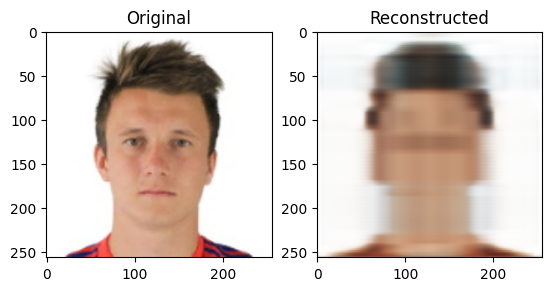

  5%|▌         | 1/20 [01:28<27:54, 88.13s/it]

Epoch [2/20], Loss: 0.0181


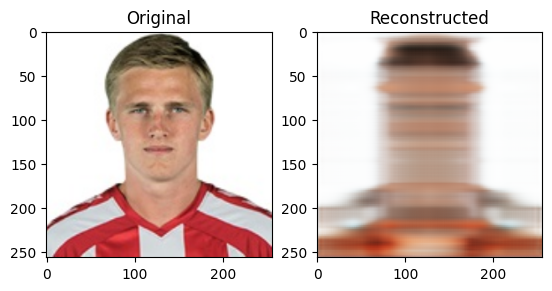

 10%|█         | 2/20 [02:50<25:29, 84.96s/it]

Epoch [3/20], Loss: 0.0177


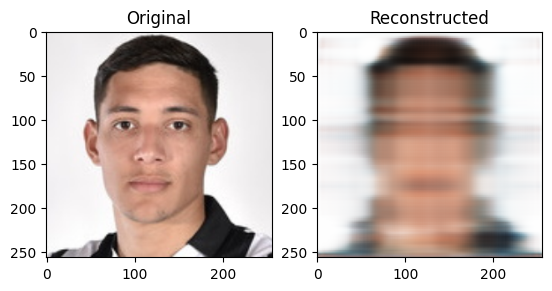

 15%|█▌        | 3/20 [04:13<23:50, 84.12s/it]

Epoch [4/20], Loss: 0.0176


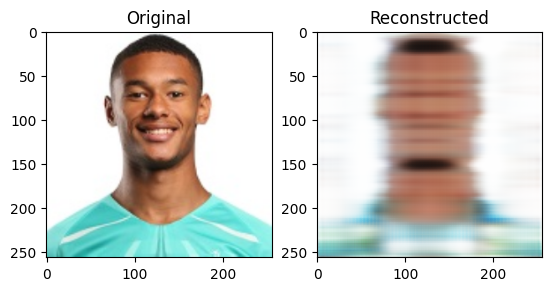

 20%|██        | 4/20 [05:36<22:17, 83.59s/it]

Epoch [5/20], Loss: 0.0178


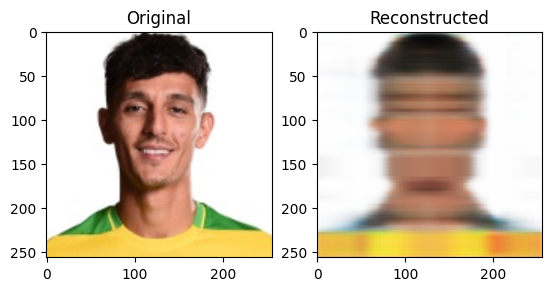

 25%|██▌       | 5/20 [06:59<20:48, 83.25s/it]

Epoch [6/20], Loss: 0.0180


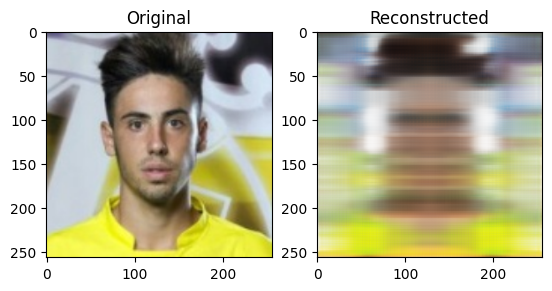

 30%|███       | 6/20 [08:22<19:23, 83.07s/it]

Epoch [7/20], Loss: 0.0181


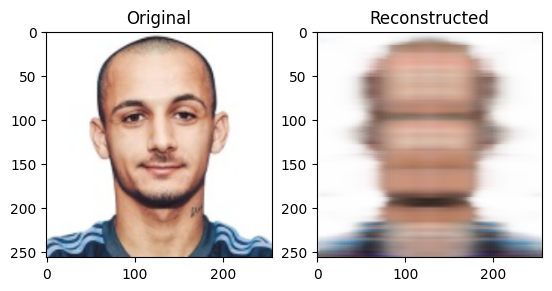

 35%|███▌      | 7/20 [09:45<17:59, 83.01s/it]

Epoch [8/20], Loss: 0.0169


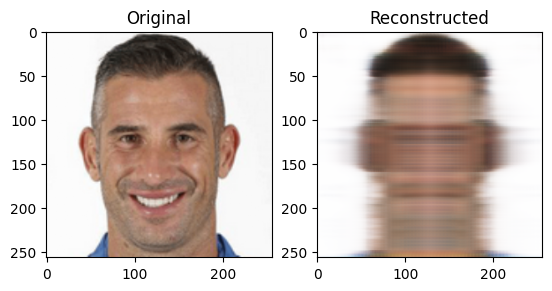

 40%|████      | 8/20 [11:07<16:34, 82.88s/it]

Epoch [9/20], Loss: 0.0179


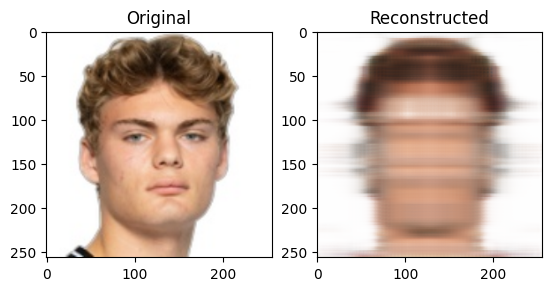

 45%|████▌     | 9/20 [12:30<15:10, 82.81s/it]

Epoch [10/20], Loss: 0.0215


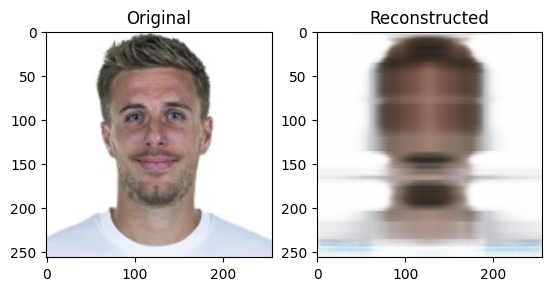

 50%|█████     | 10/20 [13:52<13:46, 82.69s/it]

Epoch [11/20], Loss: 0.0231


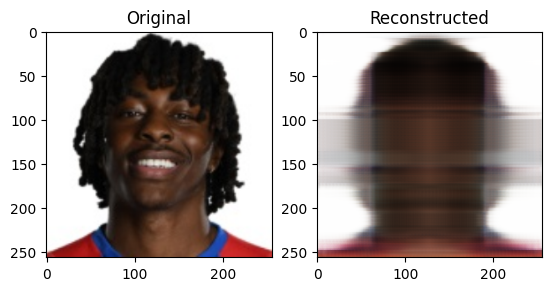

 55%|█████▌    | 11/20 [15:15<12:23, 82.65s/it]

Epoch [12/20], Loss: 0.0245


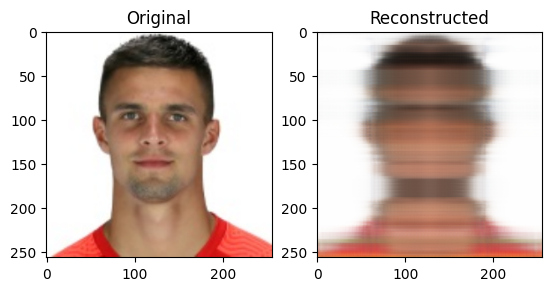

 60%|██████    | 12/20 [16:37<10:59, 82.47s/it]

Epoch [13/20], Loss: 0.0250


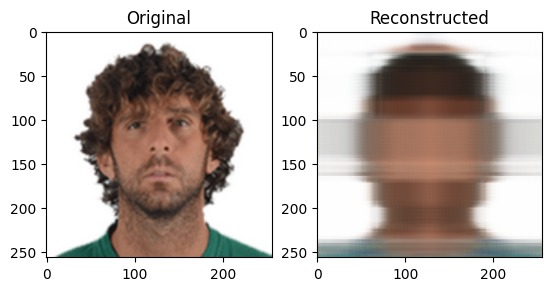

 65%|██████▌   | 13/20 [18:00<09:38, 82.57s/it]

Epoch [14/20], Loss: 0.0290


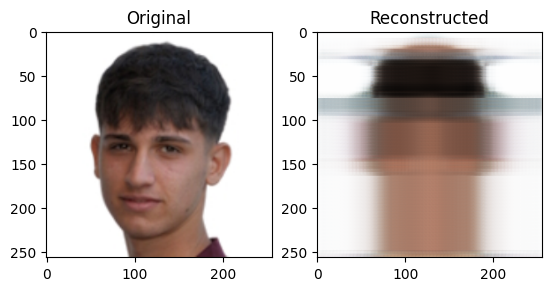

 70%|███████   | 14/20 [19:23<08:16, 82.67s/it]

Epoch [15/20], Loss: 0.0342


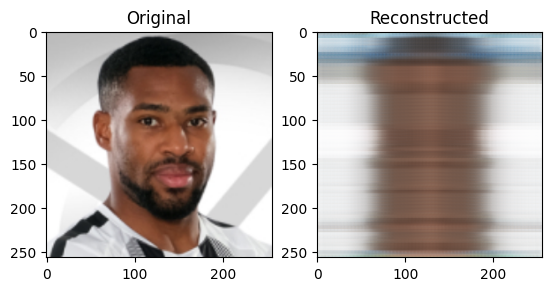

 75%|███████▌  | 15/20 [20:45<06:52, 82.59s/it]

Epoch [16/20], Loss: 0.0350


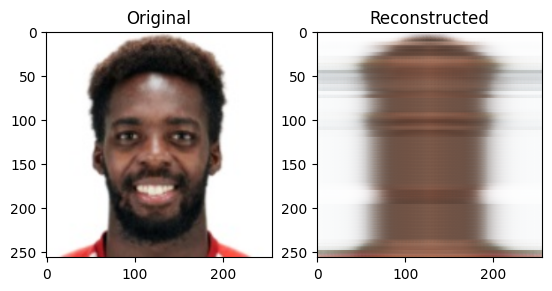

 80%|████████  | 16/20 [22:07<05:29, 82.44s/it]

Epoch [17/20], Loss: 0.0271


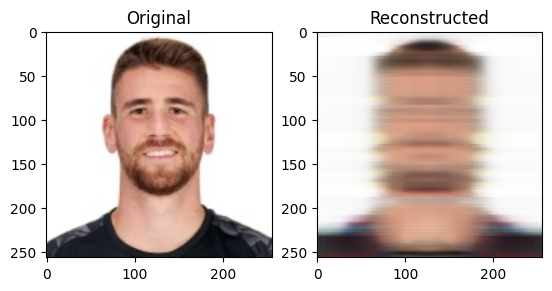

 85%|████████▌ | 17/20 [23:29<04:06, 82.26s/it]

Epoch [18/20], Loss: 0.0222


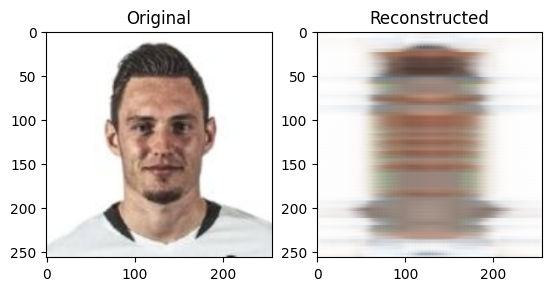

 90%|█████████ | 18/20 [24:51<02:44, 82.16s/it]

Epoch [19/20], Loss: 0.0237


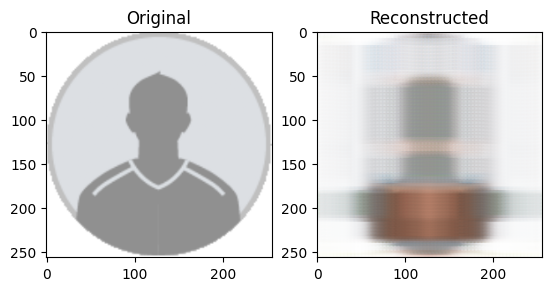

 95%|█████████▌| 19/20 [26:13<01:22, 82.09s/it]

Epoch [20/20], Loss: 0.0226


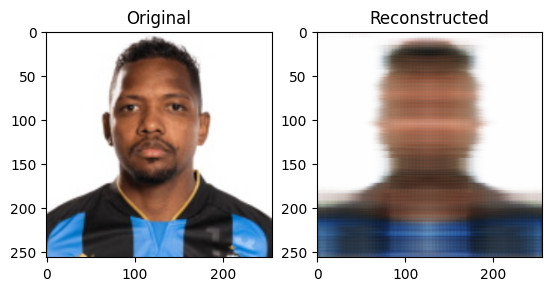

100%|██████████| 20/20 [27:35<00:00, 82.75s/it]


In [8]:

train(model, dataloader)


In [ ]:
torch.save(model, "vqvae_full_model.pth")